# Final project

The final assignment in Computational drug design.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem import AllChem as Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.rdMolDescriptors import MQNs_
import rdkit.DataStructs

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from scipy.spatial import distance
from sklearn.manifold import TSNE

from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric

from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, MolToImage
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64
from IPython.core.display import HTML

## pChEMBL value prediction

In [2]:
# load the vasopressin dataset
data = pd.read_csv("data/chembl_Vasopressin_V1a_receptor_KI.csv", delimiter = ";")

smiles = data["Smiles"]
smiles.fillna("", inplace = True)
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
data["molecule"] = molecules

## Standardization

In [3]:
sr = SaltRemover()

In [4]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [6]:
data["molecule"] = data["molecule"].apply(standardize)

In [7]:
data["molecule"].isna().sum()

56

By standardizing the coumpounds - removing salts, removing inorganics and neutralization, 56 of the compounds were lost.

In [8]:
data = data[data["molecule"].notna()].copy(deep = True)

In [9]:
data.reset_index(inplace = True)

In [10]:
data

,index,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,molecule
0,0,CHEMBL1085301,NaN,0,403.52,1,6.15,13a,COc1cc(C(=O)N2C[C@]3(C)C[C@H]2CC(C)(C)C3)ccc1-...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL1155536,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2010.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fb6c4120>
1,1,CHEMBL1084008,NaN,0,402.54,1,5.88,13f,COc1cc(C(=O)N2C[C@]3(C)C[C@H]2CC(C)(C)C3)ccc1-...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL1155536,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2010.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fb6c4b70>
2,2,CHEMBL4173250,NaN,0,524.63,1,3.99,3c,Cn1ncc2c1Nc1ccccc1N(C(=O)Cc1ccc(N3CCN(Cc4cc(O)...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4138154,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fb6b4080>
3,3,CHEMBL382301,ATOSIBAN,4,994.21,3,-3.04,Atosiban,CCOc1ccc(C[C@H]2NC(=O)CCSSC[C@@H](C(=O)N3CCC[C...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL1142309,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fb6b4530>
4,4,CHEMBL1085299,NaN,0,377.53,1,5.71,12k,COc1cc(C(=O)N2C[C@]3(C)C[C@H]2CC(C)(C)C3)ccc1-...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL1155536,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2010.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fb6b49e0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,1712,CHEMBL3342789,NaN,0,334.79,0,2.72,2a,O=S(=O)(Nc1ccnn1-c1ccccn1)c1ccc(Cl)cc1,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4138097,1,Scientific Literature,Eur J Med Chem,2017.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fc6a22b0>
1657,1713,CHEMBL4126100,NaN,0,1139.37,None,None,dOT(L8R)ortho,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4118114,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fc6ad8a0>
1658,1714,CHEMBL4129142,NaN,0,1096.34,None,None,dOTmeta,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4118114,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fc6ad030>
1659,1715,CHEMBL419667,RELCOVAPTAN,2,620.51,1,3.30,"12, SR 49059",COc1ccc(S(=O)(=O)N2c3ccc(Cl)cc3[C@](O)(c3ccccc...,Ki,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4270673,1,Scientific Literature,J Med Chem,2018.0,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc6fc68e1c0>


## Data preprocessing

In [11]:
# drop rows with unknown pChEMBL values
data = data[data["pChEMBL Value"].notna()].copy(deep = True)

In [12]:
# generate MQN descriptors
MQNs_column_names = ["MQN" + str(i) for i in list(range(1, 43))]
data[MQNs_column_names] = data["molecule"].apply(MQNs_).to_list()

In [13]:
# generate fingerprints
data["morgan_fingerprint"] = data["molecule"].apply(Chem.GetMorganFingerprintAsBitVect, args = (2, ), nBits = 1024)

## Prediction based on MQNs

In [14]:
# define the features (X) and target (y)
X_MQNs = data[MQNs_column_names]
y = data["pChEMBL Value"]

In [15]:
# split the dataset into training and testing set
X_MQNs_train, X_MQNs_test, y_train, y_test = train_test_split(X_MQNs, y, test_size = 0.35, random_state = 42)

### Random forest

In [16]:
# hyperparameter tuning
random_forest_param_grid = {
    "max_depth": [15, 21, 25, 31],
    "max_features": [3, 4, 6, 8, 10],
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [50, 100, 200]}

In [17]:
rf_mqns = GridSearchCV(RandomForestRegressor(), random_forest_param_grid, cv = 3)

In [18]:
rf_mqns.fit(X_MQNs_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15, 21, 25, 31],
                         'max_features': [3, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200]})

In [19]:
rf_mqns.best_params_

{'max_depth': 21,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

In [20]:
# get train dataset prediction and score
y_pred_train_rf_mqns = rf_mqns.predict(X_MQNs_train)

In [21]:
def print_regression_metrics(y_true, y_pred):
    print(f"R^2 {explained_variance_score(y_true, y_pred)}")
    print(f"MSE {mean_squared_error(y_true, y_pred)}")

In [22]:
def get_regression_metrics_tuple(y_true, y_pred):
    return (explained_variance_score(y_true, y_pred), mean_squared_error(y_true, y_pred))

In [23]:
print_regression_metrics(y_train, y_pred_train_rf_mqns)

R^2 0.7814984436580816
MSE 0.3588431088299641


<AxesSubplot:ylabel='pChEMBL Value'>

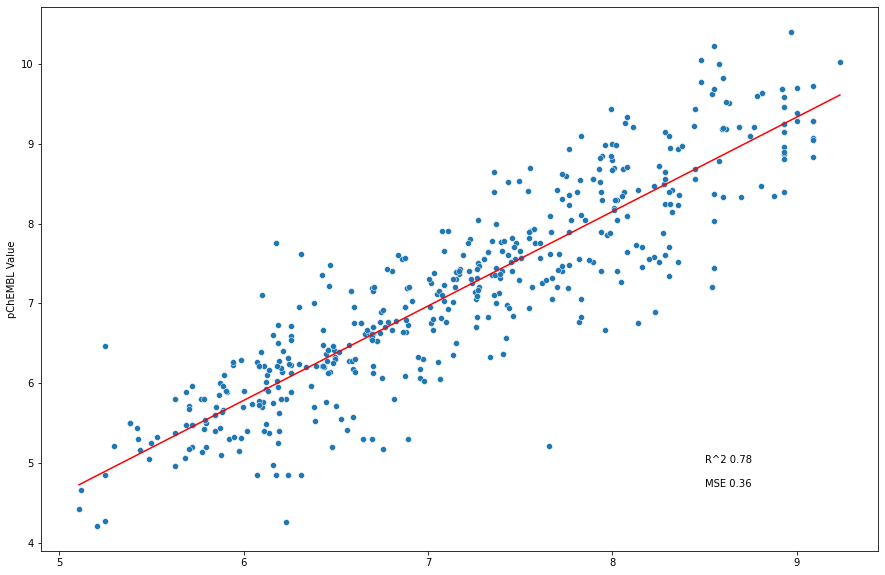

In [24]:
# visualize the train predictions
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_rf_mqns),
         np.poly1d(np.polyfit(y_pred_train_rf_mqns, y_train, 1))(np.unique(y_pred_train_rf_mqns)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train, y_pred_train_rf_mqns):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train, y_pred_train_rf_mqns):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_rf_mqns,
                y = y_train,
                legend = "brief",
                ax = ax)

### Multiple linear regression

In [25]:
# hyperparameter tuning
linear_regression_param_grid = {"fit_intercept" : [True,False],
                                "copy_X" : [True, False]}

In [26]:
lin_reg_mqns = GridSearchCV(LinearRegression(), linear_regression_param_grid, cv = 3)

In [27]:
lin_reg_mqns.fit(X_MQNs_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]})

In [28]:
lin_reg_mqns.best_params_

{'copy_X': True, 'fit_intercept': False}

In [29]:
# get the train prediction and score
y_pred_train_lin_reg_mqns = lin_reg_mqns.predict(X_MQNs_train)

In [30]:
print_regression_metrics(y_train, y_pred_train_lin_reg_mqns)

R^2 0.42816128704455914
MSE 0.9390842897450102


<AxesSubplot:ylabel='pChEMBL Value'>

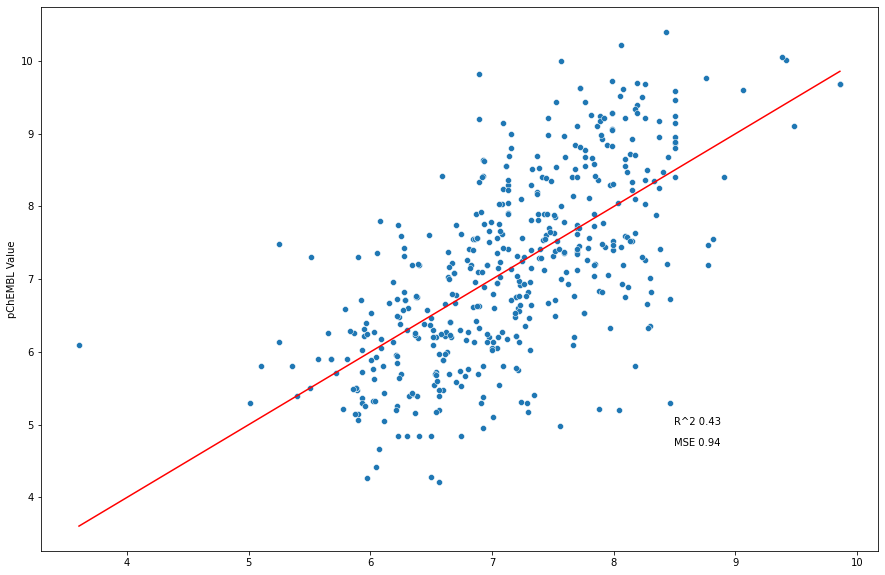

In [31]:
# visualize the train predictions
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_lin_reg_mqns),
         np.poly1d(np.polyfit(y_pred_train_lin_reg_mqns, y_train, 1))(np.unique(y_pred_train_lin_reg_mqns)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train, y_pred_train_lin_reg_mqns):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train, y_pred_train_lin_reg_mqns):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_lin_reg_mqns,
                y = y_train,
                legend = "brief",
                ax = ax)

### Support Vector Regression

In [32]:
# feature scaling
sc_X = StandardScaler()
sc_y = StandardScaler()

X_MQNs_train_scaled = sc_X.fit_transform(X_MQNs_train)

y_train_scaled = np.array(y_train).reshape(len(y_train), 1)
y_train_scaled = sc_y.fit_transform(y_train_scaled)
y_train_scaled = y_train_scaled.ravel()

In [33]:
# hyperparameter tuning
svr_param_grid = {"kernel" : ["linear", "rbf"],
                  "C" : [1, 5, 10]}

In [34]:
svr_mqns = GridSearchCV(SVR(), svr_param_grid, cv = 3)

In [35]:
svr_mqns.fit(X_MQNs_train_scaled, y_train_scaled)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'kernel': ['linear', 'rbf']})

In [36]:
svr_mqns.best_params_

{'C': 10, 'kernel': 'rbf'}

In [37]:
# get the train prediction and score
y_pred_train_svr_mqns = svr_mqns.predict(X_MQNs_train_scaled)

In [38]:
print_regression_metrics(y_train_scaled, y_pred_train_svr_mqns)

R^2 0.7811267715543095
MSE 0.21909158071647433


<AxesSubplot:>

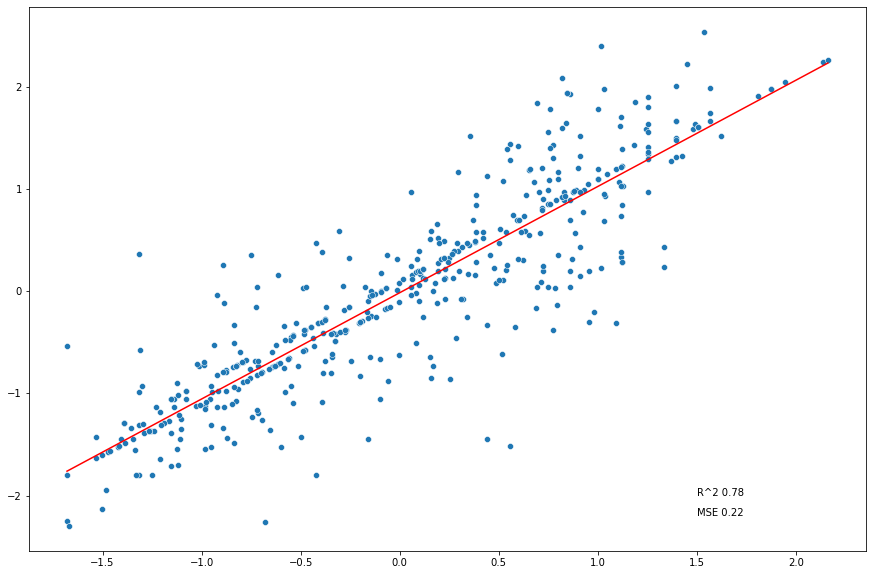

In [39]:
# visualize the train predictions
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_svr_mqns),
         np.poly1d(np.polyfit(y_pred_train_svr_mqns, y_train_scaled, 1))(np.unique(y_pred_train_svr_mqns)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train_scaled, y_pred_train_svr_mqns):.2f}", (1.5, -2))
plt.annotate(f"MSE {mean_squared_error(y_train_scaled, y_pred_train_svr_mqns):.2f}", (1.5, -2.2))
sns.scatterplot(x = y_pred_train_svr_mqns,
                y = y_train_scaled,
                legend = "brief",
                ax = ax)

## Prediction based on ECFPs

In [40]:
ECFP_column_names = ["ECFP" + str(i) for i in list(range(1, 1025))]

In [41]:
X_ECFP = pd.DataFrame(np.array(data["morgan_fingerprint"].to_list()), columns = ECFP_column_names)

In [42]:
# split the dataset into training and testing set
X_ECFP_train, X_ECFP_test, y_train, y_test = train_test_split(X_ECFP, y, test_size = 0.35, random_state = 42)

### Random forest

In [43]:
# hyperparameter tuning
random_forest_param_grid = {
    "max_depth": [15, 21, 25, 31],
    "max_features": [3, 4, 6, 8, 10],
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [50, 100, 200]}

In [44]:
rf_ecfp = GridSearchCV(RandomForestRegressor(), random_forest_param_grid, cv = 3)

In [45]:
rf_ecfp.fit(X_ECFP_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15, 21, 25, 31],
                         'max_features': [3, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200]})

In [46]:
rf_ecfp.best_params_

{'max_depth': 25,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 50}

In [47]:
# get train dataset prediction and score
y_pred_train_rf_ecfp = rf_ecfp.predict(X_ECFP_train)

In [48]:
print_regression_metrics(y_train, y_pred_train_rf_ecfp)

R^2 0.6697067597892608
MSE 0.5427641040426573


Text(0.5, 0, 'Predicted pChEBMBL Value')

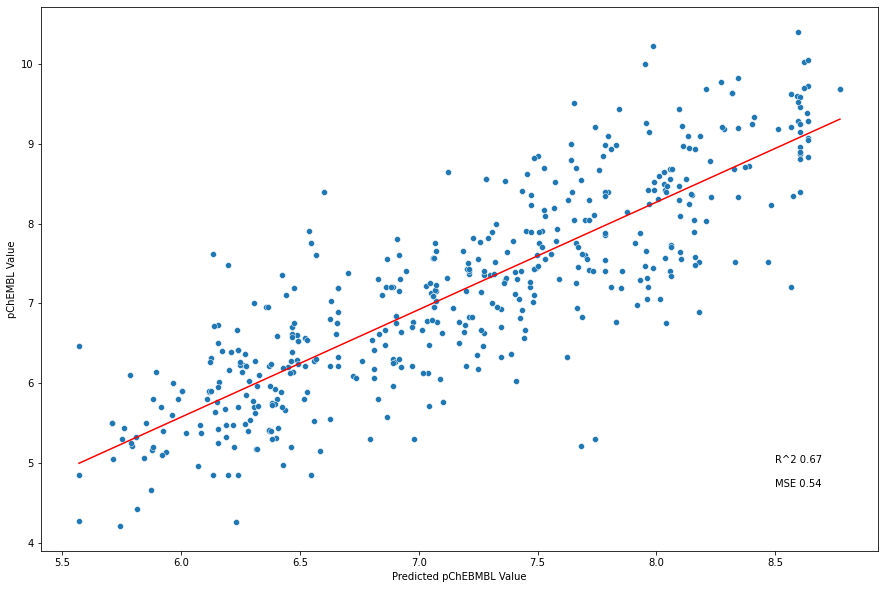

In [49]:
# visualize the train predictions
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_rf_ecfp),
         np.poly1d(np.polyfit(y_pred_train_rf_ecfp, y_train, 1))(np.unique(y_pred_train_rf_ecfp)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train, y_pred_train_rf_ecfp):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train, y_pred_train_rf_ecfp):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_rf_ecfp,
                y = y_train,
                ax = ax)
plt.xlabel("Predicted pChEBMBL Value")

### Mutiple Linear Regression

In [50]:
# hyperparameter tuning
linear_regression_param_grid = {"fit_intercept" : [True,False],
                                "copy_X" : [True, False]}

In [51]:
lin_reg_ecfp = GridSearchCV(LinearRegression(), linear_regression_param_grid, cv = 3)

In [52]:
lin_reg_ecfp.fit(X_ECFP_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]})

In [53]:
lin_reg_ecfp.best_params_

{'copy_X': True, 'fit_intercept': True}

In [54]:
# get the train prediction and score
y_pred_train_lin_reg_ecfp = lin_reg_ecfp.predict(X_ECFP_train)

In [55]:
print_regression_metrics(y_train, y_pred_train_lin_reg_ecfp)

R^2 0.9500749159769192
MSE 0.08198764170854904


<AxesSubplot:ylabel='pChEMBL Value'>

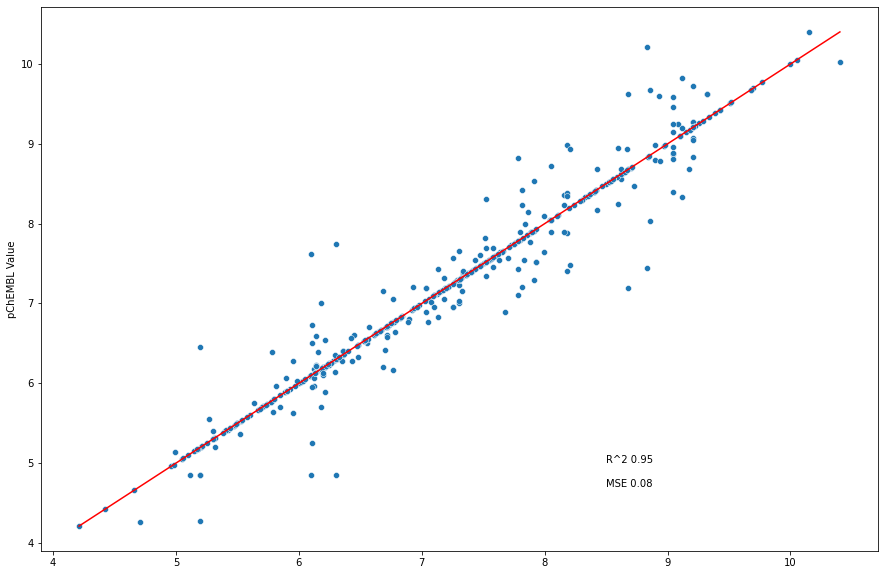

In [56]:
# visualize the train predictions
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_lin_reg_ecfp),
         np.poly1d(np.polyfit(y_pred_train_lin_reg_ecfp, y_train, 1))(np.unique(y_pred_train_lin_reg_ecfp)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train, y_pred_train_lin_reg_ecfp):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train, y_pred_train_lin_reg_ecfp):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_lin_reg_ecfp,
                y = y_train,
                legend = "brief",
                ax = ax)

### Support Vector Regression

In [57]:
# feature scaling
X_ECFP_train_scaled = sc_X.fit_transform(X_ECFP_train)

In [58]:
y_train_scaled = y_train_scaled.ravel()

In [59]:
# hyperparameter tuning
svr_param_grid = {"kernel" : ["linear", "rbf"],
                  "C" : [1, 5, 10]}

In [60]:
svr_ecfp = GridSearchCV(SVR(), svr_param_grid, cv = 3)

In [61]:
svr_ecfp.fit(X_ECFP_train_scaled, y_train_scaled)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'kernel': ['linear', 'rbf']})

In [62]:
svr_ecfp.best_params_

{'C': 1, 'kernel': 'rbf'}

In [63]:
# get the train prediction and score
y_pred_train_svr_ecfp = svr_ecfp.predict(X_ECFP_train_scaled)

In [64]:
print_regression_metrics(y_train_scaled, y_pred_train_svr_ecfp)

R^2 0.8463190956265391
MSE 0.15387196288386715


<AxesSubplot:>

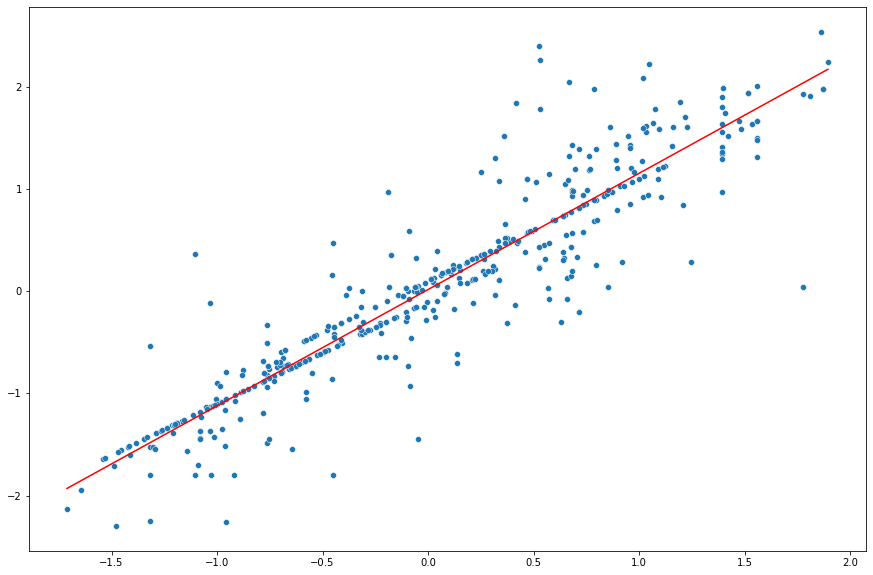

In [65]:
# visualize the train predictions
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_svr_ecfp),
         np.poly1d(np.polyfit(y_pred_train_svr_ecfp, y_train_scaled, 1))(np.unique(y_pred_train_svr_ecfp)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train_scaled, y_pred_train_svr_ecfp):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train_scaled, y_pred_train_svr_ecfp):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_svr_ecfp,
                y = y_train_scaled,
                legend = "brief",
                ax = ax)

## Applying the best model to the DrugBank dataset

|                           | MQNs R^2 | MQNs MSE | ECFP R^2 | ECFP MSE |
|---------------------------|------|------|------|------|
| Random forest             | 0.78 | 0.35 | 0.66 | 0.55 |
| Multiple linar regression | 0.43 | 0.94 | 0.95 | 0.08 |
| Support vector regression | 0.78 | 0.22 | 0.82 | 0.30 |

From the table above, we can see that the best model is in this case the multiple linear regression based on Morgan fingerprints. Below, I will use this model to predict pChEMBL Value for the DrugBank dataset and find compounds with high values that will be considered as potential ligands. Further analysis will be done on these potential ligands.

In [66]:
# a way to silence ubiquitous Rdkits "Can't kekulize" errors
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

In [67]:
# load the DrugBank dataset
drugbank = [m for m in Chem.ForwardSDMolSupplier("../data/drugbank.sdf") if m is not None]

# create the DrugBank dataframe
drugbank_morgan_fingerprint = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024) for m in drugbank]
drugbank_formulas = [m.GetProp("FORMULA") if m is not None else np.nan() for m in drugbank]
drugbank_generics = [m.GetProp("GENERIC_NAME") if m is not None else np.nan() for m in drugbank]

drugbank_df = pd.DataFrame([drugbank_formulas, drugbank_generics, drugbank, drugbank_morgan_fingerprint]).transpose()
drugbank_df.columns = ["formula", "generic_name", "molecule", "morgan_fingerprint"]

In [68]:
drugbank_ecfp = pd.DataFrame(np.array(drugbank_df["morgan_fingerprint"].to_list()), columns = ECFP_column_names)

In [69]:
drugbank_ecfp.head()

,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,ECFP10,...,ECFP1015,ECFP1016,ECFP1017,ECFP1018,ECFP1019,ECFP1020,ECFP1021,ECFP1022,ECFP1023,ECFP1024
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [70]:
# predict the PChEMBL Values
y_pred = lin_reg_ecfp.predict(drugbank_ecfp)
y_pred

array([-1.19233064e+10, -7.39210032e+09,  7.81524658e+00, ...,
        9.57094452e+10,  2.18272300e+08,  5.78590252e+10])

## Potential ligands

In [71]:
drugbank_df["pChEMBL Value"] = y_pred
drugbank_df.sort_values("pChEMBL Value", ascending = False, inplace = True)
drugbank_df.head(10)

,formula,generic_name,molecule,morgan_fingerprint,pChEMBL Value
6664,C52H74Cl2O18,Fidaxomicin,<rdkit.Chem.rdchem.Mol object at 0x7fc6ed60cc10>,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.842910e+11
759,C51H79NO13,Sirolimus,<rdkit.Chem.rdchem.Mol object at 0x7fc6e40a5a80>,"[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...",1.775123e+11
1376,C53H83NO14,Everolimus,<rdkit.Chem.rdchem.Mol object at 0x7fc6e40b2030>,"[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, ...",1.505424e+11
1899,C44H68O13,"9,10-Deepithio-9,10-Didehydroacanthifolicin",<rdkit.Chem.rdchem.Mol object at 0x7fc6e40bc760>,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.490297e+11
2518,C15H21NO6,Domoic Acid,<rdkit.Chem.rdchem.Mol object at 0x7fc6e40c8d50>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.481657e+11
2128,C29H40N2O9,Geldanamycin,<rdkit.Chem.rdchem.Mol object at 0x7fc6e40c10d0>,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.454125e+11
2719,C32H48N4O8,17-Dmag,<rdkit.Chem.rdchem.Mol object at 0x7fc6e40ccda0>,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.394557e+11
5735,C14H17FN2O3,"ISOPROPYL (2S)-2-ETHYL-7-FLUORO-3-OXO-3,4-DIHY...",<rdkit.Chem.rdchem.Mol object at 0x7fc6e3861300>,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",1.376556e+11
2957,C33H47BrN9O17P3S,Coa-S-Acetyl 5-Bromotryptamine,<rdkit.Chem.rdchem.Mol object at 0x7fc6e38299e0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.351447e+11
4397,C26H40Cl4N5O10PS,Canfosfamide,<rdkit.Chem.rdchem.Mol object at 0x7fc6e38466c0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1.330932e+11


In [72]:
drugbank_df["potential_ligand"] = (drugbank_df["pChEMBL Value"] >= 6.5).map({False: "inactive", True: "active"})
drugbank_potential_ligands = drugbank_df.loc[drugbank_df["potential_ligand"] == "active"].copy(deep = True)

In [73]:
drugbank_df["potential_ligand"].value_counts()

inactive    3786
active      3329
Name: potential_ligand, dtype: int64

3329 compounds from the DrugBank dataset were predicted to be potential ligands for the vasopressin receptor. That is 46.79 % of the whole dataset.

### Visualization

Let's visualize the potential DrugBank ligands in the chemical space.

In [92]:
# combine the dataframes
data[ECFP_column_names] = np.array(data["morgan_fingerprint"].to_list())
data["source"] = "vasopressin"
drugbank_ecfp["pChEMBL Value"] = y_pred
drugbank_ecfp["source"] = "drugbank"

combined_df = data[ECFP_column_names + ["pChEMBL Value", "source"]].append(drugbank_ecfp, ignore_index = True)

In [75]:
combined_df.head()

,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,ECFP10,...,ECFP1017,ECFP1018,ECFP1019,ECFP1020,ECFP1021,ECFP1022,ECFP1023,ECFP1024,pChEMBL Value,source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,8.42,vasopressin
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,10.00,vasopressin
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.10,vasopressin
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,9.82,vasopressin
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,9.10,vasopressin


In [76]:
# compounds with pChEMBL value > 6 are considered active
combined_df["potential_ligand"] = (combined_df["pChEMBL Value"] >= 6.5).map({False: "inactive", True: "active"})

In [77]:
sparse_mat = distance.pdist(combined_df[ECFP_column_names + ["pChEMBL Value"]], metric = "jaccard")
dist_mat = distance.squareform(sparse_mat)

In [78]:
pd.DataFrame(dist_mat).to_csv("dist_mat_project.csv")

In [79]:
clf = TSNE(n_components = 2, metric = "precomputed")
tsne = clf.fit_transform(dist_mat)

/Users/katerina/Applications/miniconda3/envs/pocitacovy_navrh_leciv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/katerina/Applications/miniconda3/envs/pocitacovy_navrh_leciv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/katerina/Applications/miniconda3/envs/pocitacovy_navrh_leciv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [80]:
combined_df[["tsne_x", "tsne_y"]] = tsne.tolist()

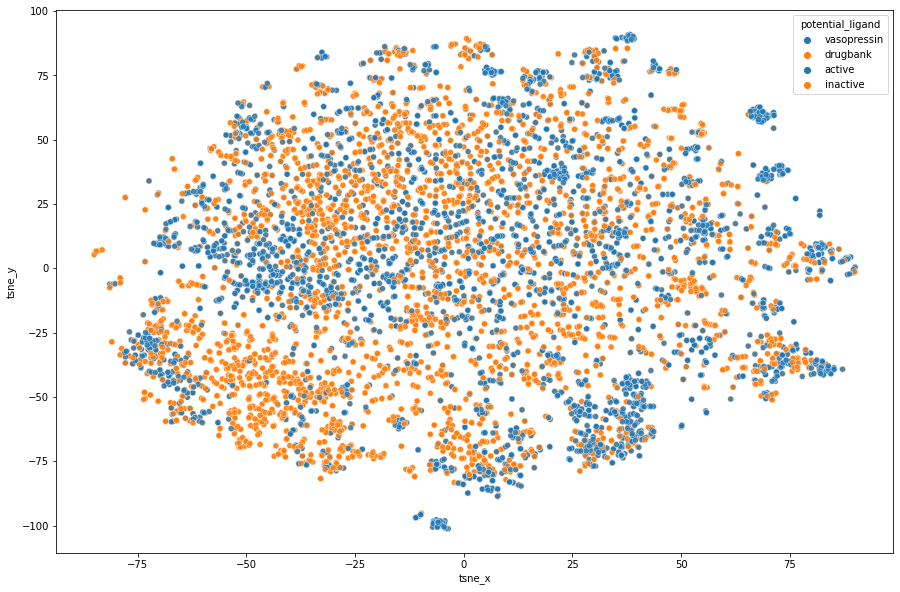

In [81]:
fig, ax = plt.subplots(figsize = (15, 10))
plot = sns.scatterplot(x = "tsne_x", y = "tsne_y", data = combined_df, hue = "source", legend = "brief", ax = ax, alpha = 0.75)
plot = sns.scatterplot(x = "tsne_x", y = "tsne_y", data = combined_df, hue = "potential_ligand", legend = "brief", ax = ax, alpha = 0.75)

### Scaffold analysis

In [82]:
def third_scaffold_drugbank(molecule):
    Chem.rdmolops.RemoveStereochemistry(molecule)
    scaffold = GetScaffoldForMol(molecule)
    try:
        scaffold_generic = MakeScaffoldGeneric(scaffold)
    except ValueError:
        return None
    
    try:
        scaffold_scaffold_generic = GetScaffoldForMol(scaffold_generic)
    except ValueError:
        return None
    
    return scaffold_scaffold_generic

In [83]:
drugbank_potential_ligands["scaffold_scaffold_generic"] = drugbank_potential_ligands["molecule"].apply(third_scaffold_drugbank)

In [84]:
drugbank_potential_ligands["scaffold_smiles"] = [Chem.MolToSmiles(mol) if mol else None for mol in drugbank_potential_ligands["scaffold_scaffold_generic"]]

In [85]:
drugbank_potential_ligands_scaffold_counts = drugbank_potential_ligands["scaffold_smiles"].value_counts()
drugbank_potential_ligands_scaffold_counts = drugbank_potential_ligands_scaffold_counts.sort_values(ascending = False)

In [86]:
def mol2display_png(mol):
    """Format RDKit mol for direct inline display."""
    d2d = rdMolDraw2D.MolDraw2DCairo(400, 400)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    buffer = BytesIO(d2d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [88]:
drugbank_potential_ligands_scaffold_counts = pd.DataFrame(drugbank_potential_ligands["scaffold_smiles"].value_counts())
drugbank_potential_ligands_scaffold_counts["molecule"] = drugbank_potential_ligands_scaffold_counts.index.map(Chem.MolFromSmiles)
drugbank_potential_ligands_scaffold_counts["scaffold_probability"] = drugbank_potential_ligands_scaffold_counts["scaffold_smiles"].apply(lambda x: (x / len(drugbank_potential_ligands_scaffold_counts)) * 100)
drugbank_potential_ligands_scaffold_counts

,scaffold_smiles,molecule,scaffold_probability
C1CCCCC1,471,<rdkit.Chem.rdchem.Mol object at 0x7fc6e407ef80>,52.449889
,231,<rdkit.Chem.rdchem.Mol object at 0x7fc6b05cee90>,25.723831
C1CCC2C(C1)CCC2C1CCCC1,141,<rdkit.Chem.rdchem.Mol object at 0x7fc6fc689d50>,15.701559
C1CCC(CC2CCCCC2)CC1,112,<rdkit.Chem.rdchem.Mol object at 0x7fc6fc684210>,12.472160
C1CCC(C2CCCC2)CC1,109,<rdkit.Chem.rdchem.Mol object at 0x7fc70072ae40>,12.138085
...,...,...,...
C1CCC(CCC2CCCC(CC3CC4CCCCC4CC3C3CCCCC3)C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x7fc6b09aeb70>,0.111359
C1CCC(C2CC3(CC4CCCCC4C3)CC2CCC2CCC(C3CCCC3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x7fc6b09aebc0>,0.111359
C(CCCC1CCCC1)CCCC(CCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CC1CCC2CCCCC2C1,1,<rdkit.Chem.rdchem.Mol object at 0x7fc6b09aec10>,0.111359
C1CCC(CCCCC2CCC3C(CCCC3C3CCC(CCC4CCCCC4)CC3)C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x7fc6b09aec60>,0.111359


As we can see in the table above, the most common scaffold forms up to 52 % of all of the potential ligands found in the DrugBank dataset.

,scaffold_smiles,molecule,scaffold_probability
C1CCCCC1,471,,52.449889
,231,,25.723831
C1CCC2C(C1)CCC2C1CCCC1,141,,15.701559
C1CCC(CC2CCCCC2)CC1,112,,12.472160
C1CCC(C2CCCC2)CC1,109,,12.138085
C1CCC2CCCC2C1,96,,10.690423
C1CCC2CCCCC2C1,83,,9.242762
C1CCC2C(C1)CCC1C3CCCC3CCC21,80,,8.908686
C1CCCC1,59,,6.570156
C1CCC(C2CCCCC2)CC1,52,,5.790646

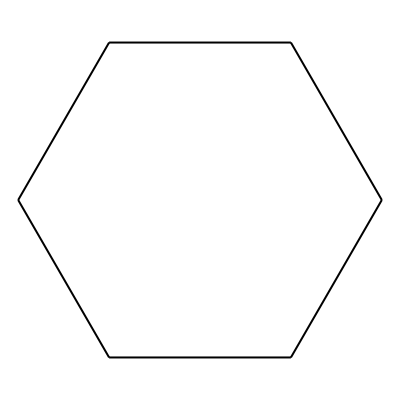
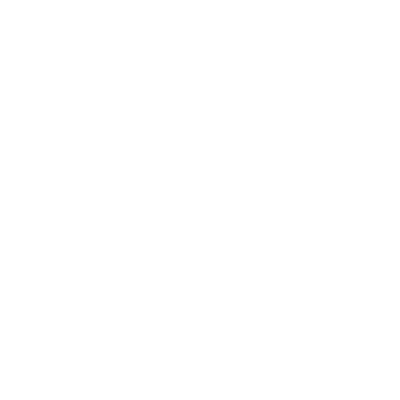
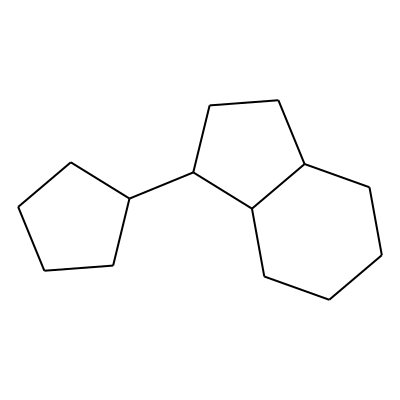
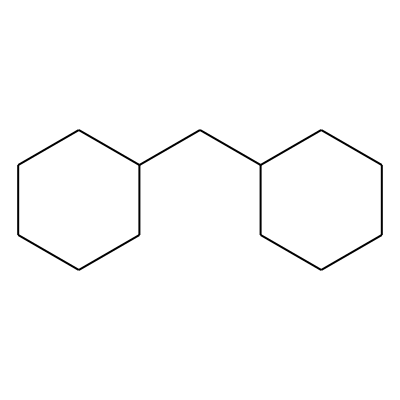
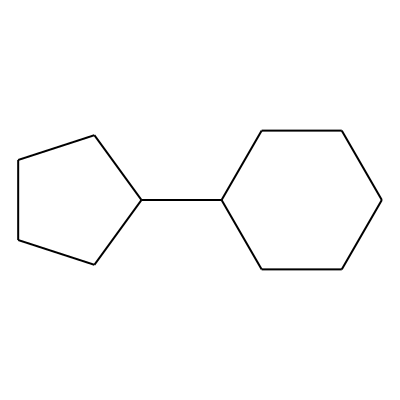
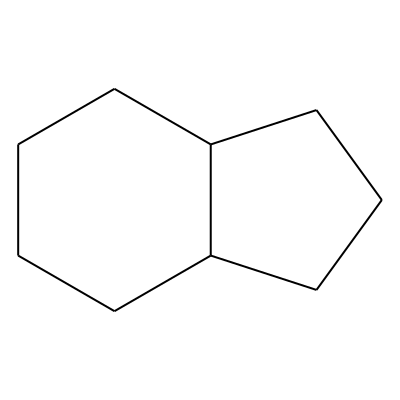
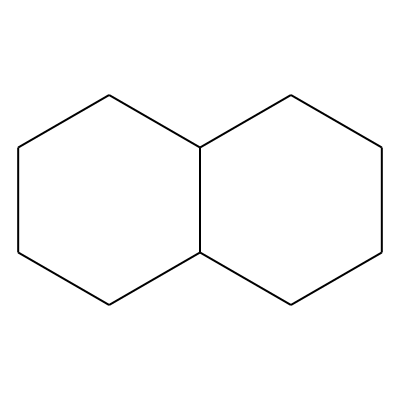
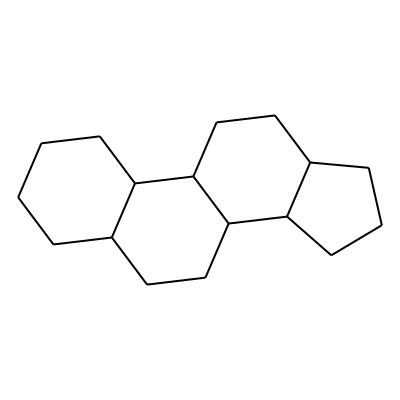
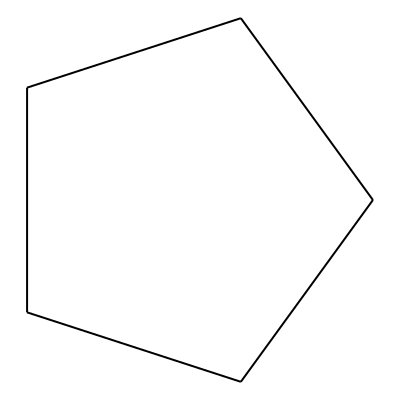
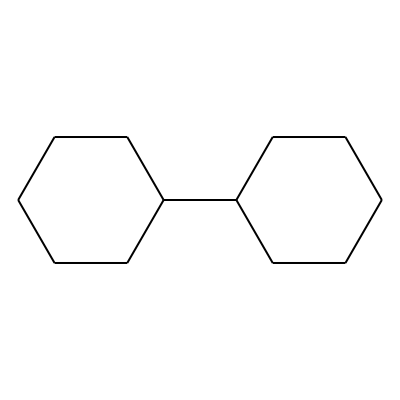

In [89]:
# visualizing top ten most common scaffolds
HTML(drugbank_potential_ligands_scaffold_counts.head(10).to_html(formatters = {"molecule": mol2display_png}, escape = False))

In [90]:
top_ten_scaffold_smiles = drugbank_potential_ligands_scaffold_counts.index[:10]
drugbank_potential_ligands["top_ten_scaffolds"] = drugbank_potential_ligands["scaffold_smiles"].apply(str).isin(top_ten_scaffold_smiles)

,formula,generic_name,molecule,morgan_fingerprint,pChEMBL Value,potential_ligand,scaffold_scaffold_generic,scaffold_smiles,top_ten_scaffolds
2518,C15H21NO6,Domoic Acid,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",1.481657e+11,active,,C1CCCC1,True
5735,C14H17FN2O3,"ISOPROPYL (2S)-2-ETHYL-7-FLUORO-3-OXO-3,4-DIHYDROQUINOXALINE-1(2H)-CARBOXYLATE",,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...]",1.376556e+11,active,,C1CCC2CCCCC2C1,True
4397,C26H40Cl4N5O10PS,Canfosfamide,,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...]",1.330932e+11,active,,C1CCCCC1,True
4182,C27H46O2,"(3BETA)-CHOLEST-5-ENE-3,25-DIOL",,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",1.221708e+11,active,,C1CCC2C(C1)CCC1C3CCCC3CCC21,True
5420,C13H19AsF3NO3,"1-(2-nitrophenyl)-2,2,2-trifluoroethyl]-arsenocholine",,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...]",1.116755e+11,active,,C1CCCCC1,True
5246,C19H24O2,"ANDROSTA-1,4-DIENE-3,17-DIONE",,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",1.041104e+11,active,,C1CCC2C(C1)CCC1C3CCCC3CCC21,True
473,C25H31F3O5S,Fluticasone Propionate,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",1.021385e+11,active,,C1CCC2C(C1)CCC1C3CCCC3CCC21,True
3022,C28H48N7O17P3S2,3-Thiaoctanoyl-Coenzyme A,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",9.858085e+10,active,,C1CCC2C(C1)CCC2C1CCCC1,True
6214,C14H16N2O5,"4-[4-(2,5-DIOXO-PYRROLIDIN-1-YL)-PHENYLAMINO]-4-HYDROXY-BUTYRIC ACID",,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",9.634327e+10,active,,C1CCC(C2CCCC2)CC1,True
1318,C19H30O2,4-Androstenediol,,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
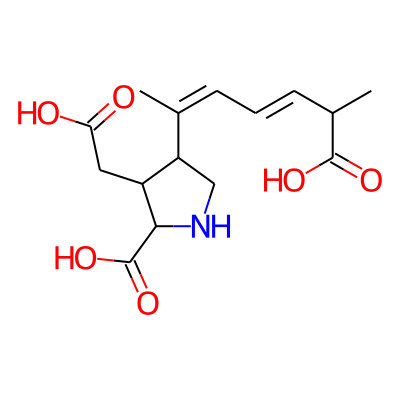
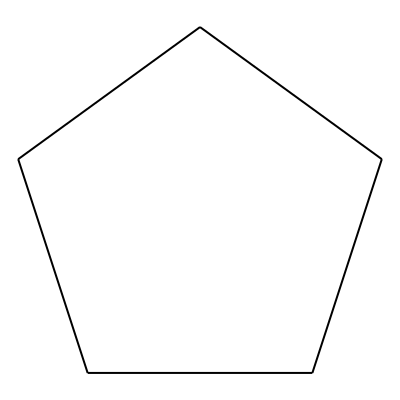
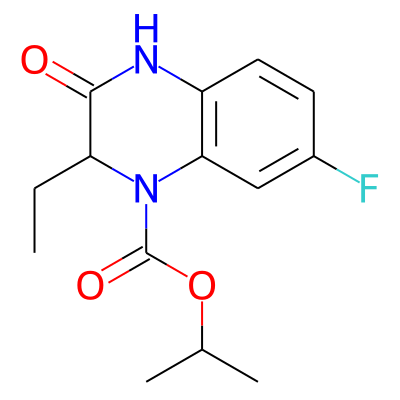
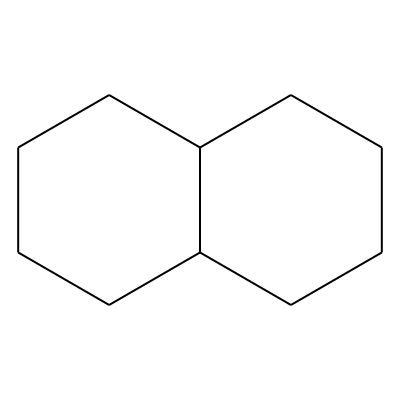
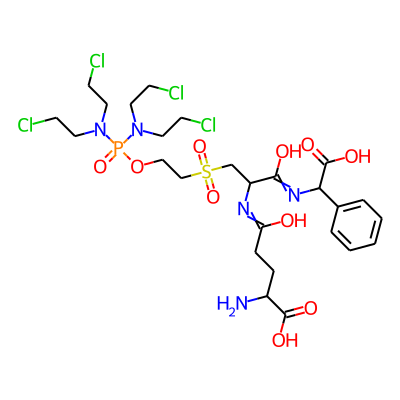
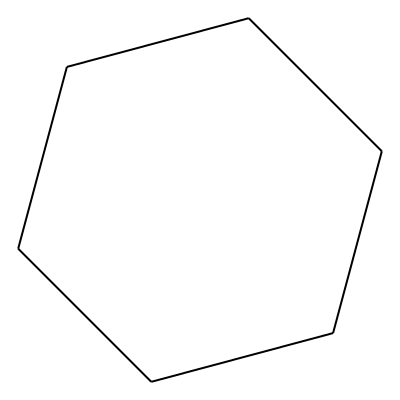
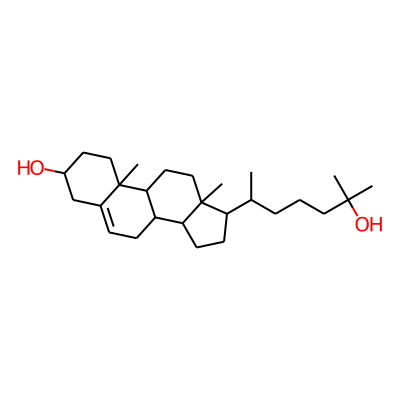
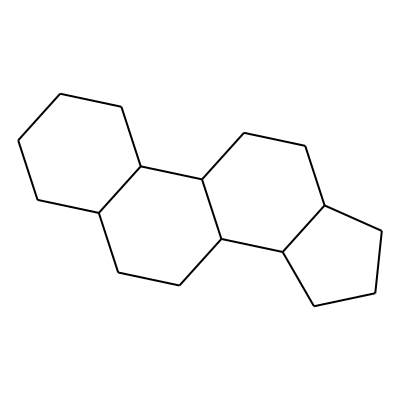
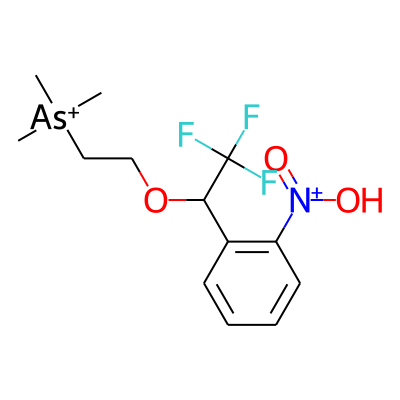
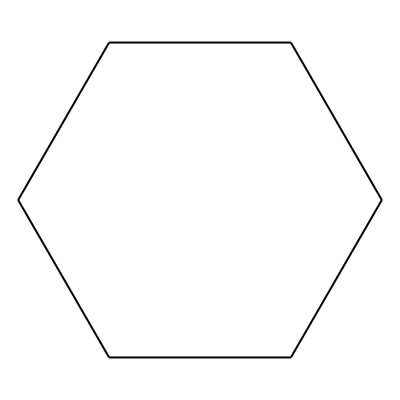
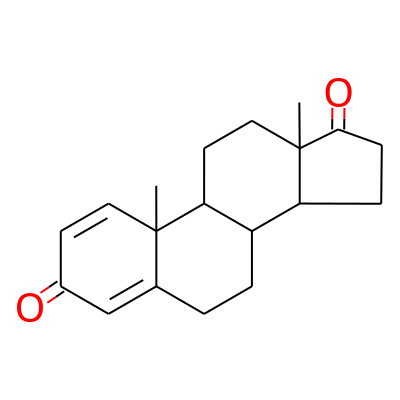
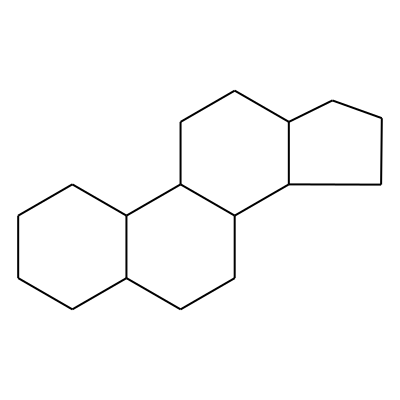
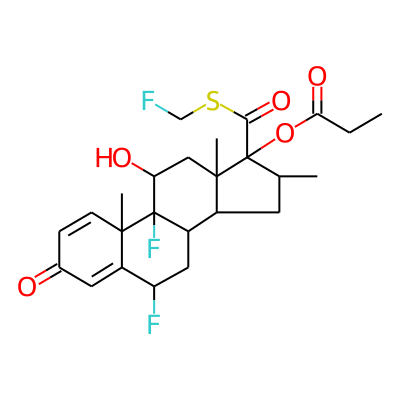
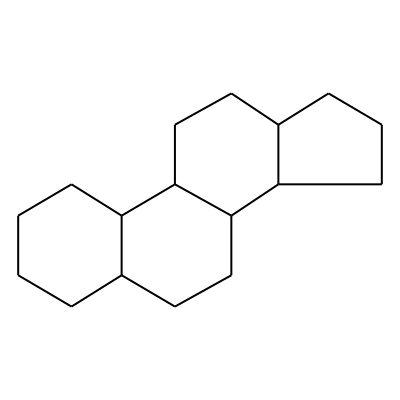
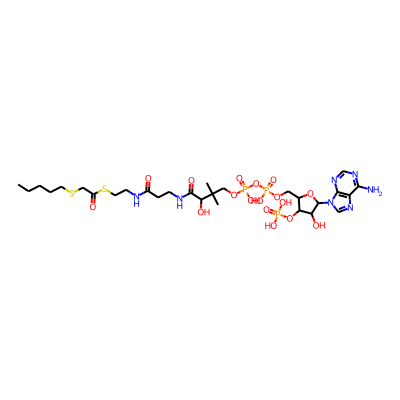
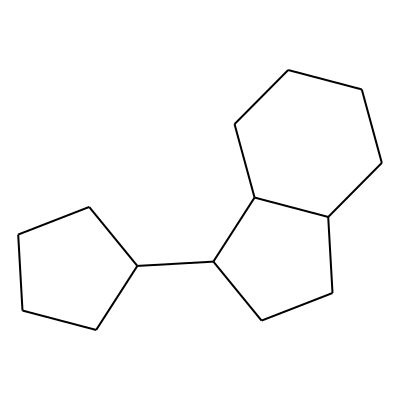
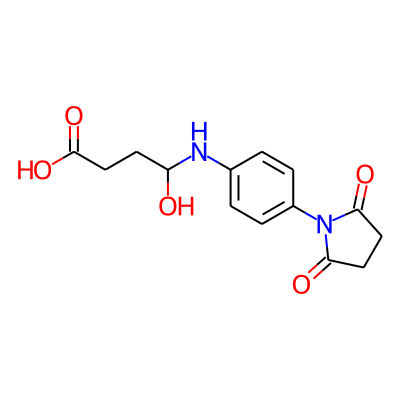
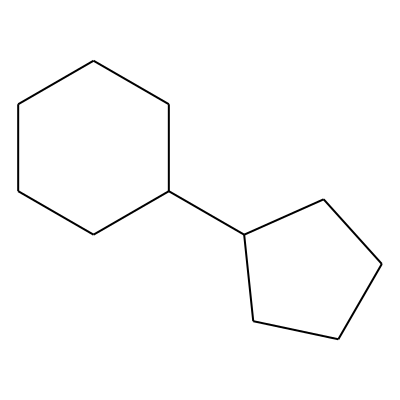
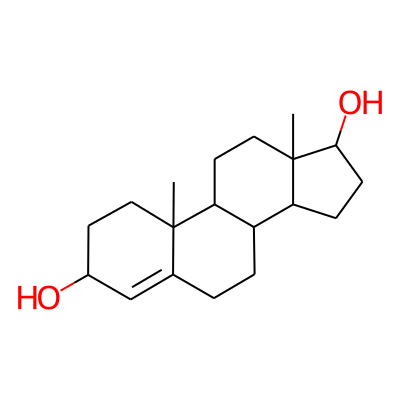
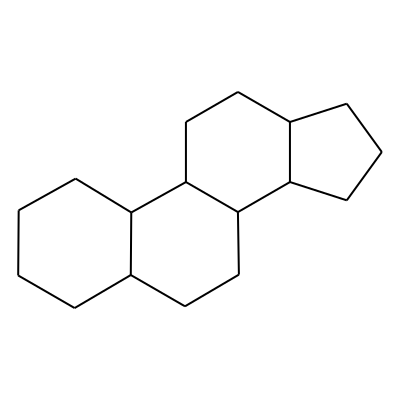

In [91]:
# the table below represents the most active ligands from the DrugBank dataset and their scaffolds
HTML(drugbank_potential_ligands.loc[drugbank_potential_ligands["top_ten_scaffolds"] == True].head(10).to_html(formatters = {"molecule": mol2display_png, "scaffold": mol2display_png, "scaffold_scaffold_generic": mol2display_png}, escape = False))